In [68]:
import GWPhotonCounting
import jax.numpy as jnp
import jax.scipy as jsp

from matplotlib.markers import MarkerStyle
import matplotlib as mpl

import matplotlib.pyplot as plt

frequencies = jnp.sort(jnp.fft.fftfreq(2**13, d=1/1e4))
detector = GWPhotonCounting.detector.Detector(frequencies, 'data/CE1_shot_psd.csv', 'data/CE1_classical_quanta.csv', 
                                              gamma=100, random_seed=1632, N_frequency_spaces=10)

In [69]:
LorentzianModel = GWPhotonCounting.signal.PostMergerLorentzian()

KNNModel = GWPhotonCounting.signal.PostMergerKNN(knn_file_path='/Users/ethanpayneadmin/Research/code_libraries/apr4_knn_gw_model_2024/KNN_Models/APR4-knn_model-N100')

/opt/homebrew/anaconda3/envs/jax/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [70]:
PM_strain = KNNModel.generate_strain(detector, frequencies, 2.4, 0, 1e-1, 0, 0.5,0.0, 0.0)

#PM_strain = LorentzianModel.generate_strain(detector, frequencies, 3e3, 100, 5e-22, 0, 0)[0]

#PM_strain = 1e-24 * detector.filter_functions[0]

In [71]:
expected_signal_photon_count = detector.calculate_signal_photon_expectation(PM_strain, frequencies)

In [72]:
print(jnp.max(expected_signal_photon_count),jnp.argmax(expected_signal_photon_count), detector.filter_labels[jnp.argmax(expected_signal_photon_count)])
print(jnp.sum(expected_signal_photon_count), jnp.sqrt(jnp.sum(expected_signal_photon_count)*2))

0.03775967117910652 30 (2888.8888888888887, -0.015555555555555555, 1.5707963267948966)
0.08113144274985025 0.4028186757086872


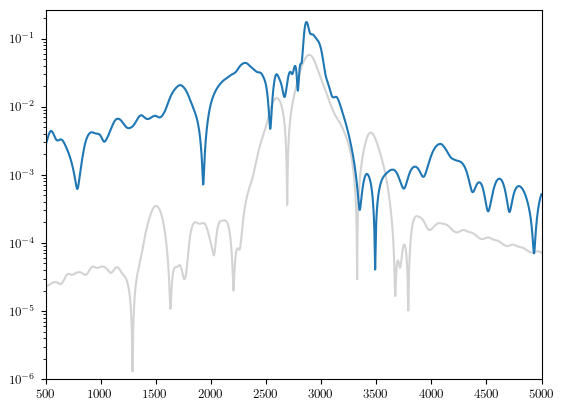

In [73]:
plt.semilogy(frequencies, jnp.abs(PM_strain)/jnp.sum(jnp.abs(PM_strain))*1e2)
plt.xlim(500,5000)
plt.ylim(1e-6,)
plt.semilogy(frequencies, jnp.abs(detector.filter_functions[jnp.argmax(expected_signal_photon_count)]).T, color='lightgrey',zorder=-100)
plt.show()

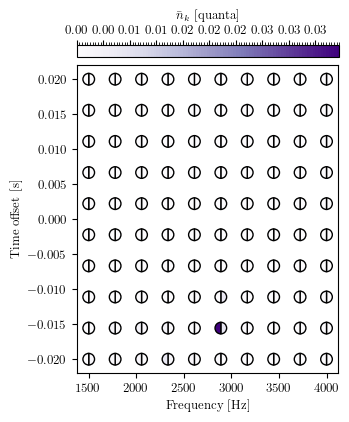

In [74]:
# Make plot for the n_exp_photons 

fig = GWPhotonCounting.plotting.generate_count_plot((expected_signal_photon_count), detector)

In [75]:
poisson_likelihood = GWPhotonCounting.distributions.PoissonPhotonLikelihood()

#noise_likelihood = GWPhotonCounting.distributions.GeometricPhotonLikelihood()
noise_likelihood = GWPhotonCounting.distributions.PhaseQuadraturePhotonLikelihood()

mixture_likelihood = GWPhotonCounting.distributions.MixturePhotonLikelihood(poisson_likelihood, noise_likelihood)


In [79]:
observed_photons, observed_signal_photons, observed_noise_photons = \
    mixture_likelihood.generate_realization(
        expected_signal_photon_count, detector.noise_photon_expectation)

print('Observed photons count: ', jnp.sum(observed_photons))
print(f'Observed signal (noise) photons: {jnp.sum(observed_signal_photons)} ({jnp.sum(observed_noise_photons)})')
print('Expected photon count where observed photons are: ', expected_signal_photon_count[observed_photons > 0])


Observed photons count:  1.0
Observed signal (noise) photons: 0 (1.0)
Expected photon count where observed photons are:  [9.99658426e-14]


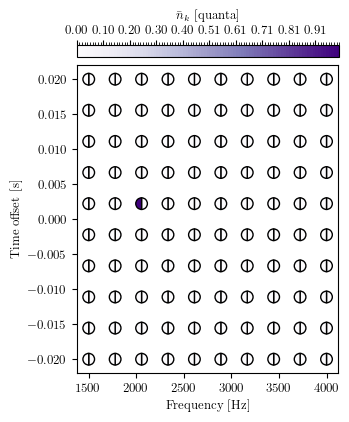

In [80]:
fig = GWPhotonCounting.plotting.generate_count_plot(observed_photons, detector)

In [81]:
print(poisson_likelihood(observed_photons, expected_signal_photon_count))
print(noise_likelihood(observed_photons, detector.noise_photon_expectation))
print(mixture_likelihood(observed_photons, expected_signal_photon_count, detector.noise_photon_expectation))

-35.31339665056409
-12.250209034710217
-12.331340477387934


In [88]:
import numpyro
import jax
import numpy as np
import numpyro.infer.initialization as init
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az


def model(n_true_bank):
    
    A = 5e-23#numpyro.sample('A', dist.Uniform(0,1e-19))
    f0 = numpyro.sample('f0', dist.Uniform(1.5e3, 4e3))
    gamma = 100#numpyro.sample('gamma', dist.Uniform(10,2e3))
    phase = 0#numpyro.sample('phase', dist.Uniform(0,jnp.pi)) # TODO maybe this only needs to be half of the range
    t0s = jnp.linspace(-0.02, 0.02, 100)
    
    n_pm_model = LorentzianModel.generate_photon_count(detector, frequencies, f0=f0, gamma=gamma, A=A, phase=phase, t0=t0s)
    
    
    log_likelihood_noise = noise_likelihood(
        n_true_bank, detector.noise_photon_expectation)

    log_likelihood_postmerger = mixture_likelihood(
        n_true_bank, n_pm_model, detector.noise_photon_expectation)
    
    numpyro.factor(
        'log_likelihood', log_likelihood_postmerger - log_likelihood_noise)
    #numpyro.factor('log_likelihood', log_likelihood_postmerger)

In [89]:
n_warmup = 100#1000
n_sample = 500#1000
n_chains = 2

kernel = NUTS(model, target_accept_prob=0.8)
mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_sample, num_chains=n_chains)
mcmc.run(jax.random.PRNGKey(np.random.randint(1<<32)), observed_photons)

fit_lorentzian_n = az.from_numpyro(mcmc)

/var/folders/g5/1z5h16_52m57mrb0qff9806m0000gp/T/ipykernel_46303/2578047570.py:6: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_sample, num_chains=n_chains)
sample: 100%|██████████| 600/600 [01:45<00:00,  5.71it/s, 9 steps of size 6.10e-01. acc. prob=0.77] 


array([[<Axes: title={'center': 'f0'}>, <Axes: title={'center': 'f0'}>]],
      dtype=object)

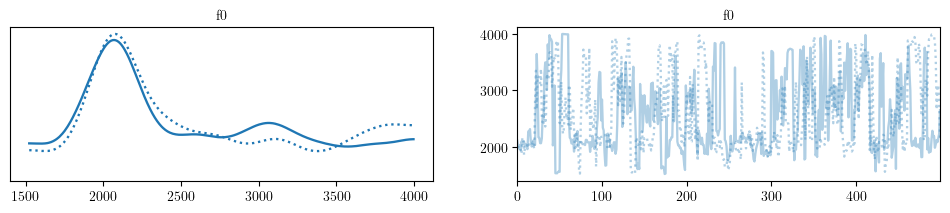

In [90]:
az.plot_trace(fit_lorentzian_n)

(array([ 20.,  15.,  10.,  24.,  51.,  82., 120., 112.,  45.,  34.,  34.,
         25.,  28.,  27.,  24.,  21.,  25.,  17.,  37.,  31.,  27.,  14.,
         17.,  20.,  12.,  24.,  25.,  25.,  31.,  23.]),
 array([1520.9843865 , 1603.54501471, 1686.10564293, 1768.66627114,
        1851.22689935, 1933.78752757, 2016.34815578, 2098.90878399,
        2181.4694122 , 2264.03004042, 2346.59066863, 2429.15129684,
        2511.71192506, 2594.27255327, 2676.83318148, 2759.3938097 ,
        2841.95443791, 2924.51506612, 3007.07569434, 3089.63632255,
        3172.19695076, 3254.75757897, 3337.31820719, 3419.8788354 ,
        3502.43946361, 3585.00009183, 3667.56072004, 3750.12134825,
        3832.68197647, 3915.24260468, 3997.80323289]),
 <BarContainer object of 30 artists>)

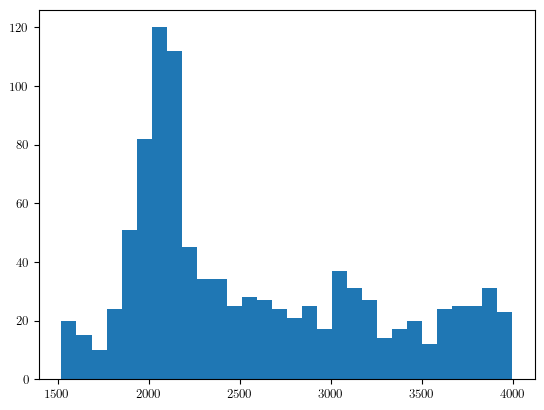

In [91]:
plt.hist(fit_lorentzian_n.posterior['f0'].values.flatten(),bins=30)

In [65]:
from corner import corner

fig = corner(fit_lorentzian_n.posterior, plot_datapoints=False, fill_contours=True, plot_density=False, color='C4', levels=[0.5,0.9], smooth=0.7, 
      var_names=['A', 'f0', 'gamma'], labels=[r'A [1/$\sqrt{Hz}$]', 'f0 [Hz]', r'$\gamma$ [Hz]'], hist_kwargs={'density':True}, truths=[None, None, None], truth_color='k')

KeyError: 'var names: "[\'A\' \'gamma\'] are not present" in dataset'